In [60]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append("../src")
from utility import HCP
import ot
import torch
import time

In [61]:
# Max-Sliced Wasserstein
def Maxsw(x,y,nproj=500):

    proj = np.zeros((nproj,2))

    for i in range(nproj):
        proj[i,0] = np.cos(i*np.pi*2/nproj)
        proj[i,1] = np.sin(i*np.pi*2/nproj)
    xp = x@proj.T
    yp = y@proj.T

    xy = np.mean((np.sort(xp,0)-np.sort(yp,0))**2,0)
    return np.sqrt(np.max(xy))


# GSW
class GSW():
    def __init__(self,ftype='linear',nofprojections=10,degree=2,use_cuda=False):
        self.ftype=ftype
        self.nofprojections=nofprojections
        self.degree=degree
        if torch.cuda.is_available() and use_cuda:
            self.device=torch.device('cuda')
        else:
            self.device=torch.device('cpu')

    def gsw(self,X,Y,theta=None):
    
        N,dn = X.shape
        M,dm = Y.shape
        assert dn==dm and M==N
        if theta is None:
            theta=self.random_slice(dn)

        Xslices=self.get_slice(X,theta)
        Yslices=self.get_slice(Y,theta)

        Xslices_sorted=torch.sort(Xslices,dim=0)[0]
        Yslices_sorted=torch.sort(Yslices,dim=0)[0]
        return torch.sqrt(torch.mean((Xslices_sorted-Yslices_sorted)**2))


    def get_slice(self,X,theta):
        if self.ftype=='linear':
            return self.linear(X,theta)
        elif self.ftype=='poly':
            return self.poly(X,theta)
        else:
            raise Exception('Defining function not implemented')

    def random_slice(self,dim):
        if self.ftype=='linear':
            theta=torch.randn((self.nofprojections,dim))
            theta=torch.stack([th/torch.sqrt((th**2).sum()) for th in theta])
        elif self.ftype=='poly':
            dpoly=self.homopoly(dim,self.degree)
            theta=torch.randn((self.nofprojections,dpoly))
            theta=torch.stack([th/torch.sqrt((th**2).sum()) for th in theta])
        return theta.to(self.device)

    def linear(self,X,theta):
        if len(theta.shape)==1:
            return torch.matmul(X,theta)
        else:
            return torch.matmul(X,theta.t())

    def poly(self,X,theta):
        N,d=X.shape
        assert theta.shape[1]==self.homopoly(d,self.degree)
        powers=list(self.get_powers(d,self.degree))
        HX=torch.ones((N,len(powers))).to(self.device)
        for k,power in enumerate(powers):
            for i,p in enumerate(power):
                HX[:,k]*=X[:,i]**p
        if len(theta.shape)==1:
            return torch.matmul(HX,theta)
        else:
            return torch.matmul(HX,theta.t())

    def get_powers(self,dim,degree):
        if dim == 1:
            yield (degree,)
        else:
            for value in range(degree + 1):
                for permutation in self.get_powers(dim - 1,degree - value):
                    yield (value,) + permutation

    def homopoly(self,dim,degree):
        return len(list(self.get_powers(dim,degree)))

modes = ['linear', 'poly', 'poly']
titles = ['Linear', 'Poly 3', 'Poly 5']
degrees = [1, 3, 5]
gsw = list()

for k in range(3):
    gsw.append([GSW(ftype=modes[j], degree=degrees[j], nofprojections=50) for j in range(k+1)])


# generate data function
def make_ring(n,r=1):
    x = np.zeros((n,2))

    for i in range(n):
        x[i,0] = np.cos(i*np.pi*2/n)
        x[i,1] = np.sin(i*np.pi*2/n)
    
    return x*r

# mixture gaussian case

In [62]:
# how many alpha: L  and  replications: R
L = 11
R = 20

d = 2
n = 1000
x = np.zeros((n,d))
y = np.zeros((n,d))
xx = [None]*L
yy = [None]*L

# m clusters
m = 10
nm = np.int32(n/m) 
sd = 0.1

In [63]:
np.random.seed(2022)

w = np.zeros(L)
ws = np.zeros(L)
hcp = np.zeros(L)

sw = np.zeros(L)
maxsw = np.zeros(L)
gsw3 = np.zeros(L)
gsw5 = np.zeros(L)


tw = 0
thcp = 0
tsw = 0
tmaxsw = 0
tgsw5 = 0
tws = 0



for l in range(L):

    meanx = make_ring(m,1)

    meany = np.zeros((m,2))
    meany[0,1] = l*0.2
    meany[1:,:] = make_ring(m-1,1)

    for r in range(R):

        # generate samples
        for i in range(m):
            x[i*nm:(i+1)*nm,:] = sd * np.random.randn(nm,2)+meanx[i,:] 
            y[i*nm:(i+1)*nm,:] = sd * np.random.randn(nm,2)+meany[i,:] 

        # SW
        stime = time.time()
        sw[l] += ot.sliced.sliced_wasserstein_distance(x, y, seed=2022) 
        tsw += time.time()-stime

        # max-SW
        stime = time.time()
        maxsw[l] += Maxsw(x, y) 
        tmaxsw += time.time()-stime

        xT = torch.from_numpy(x).float()
        yT = torch.from_numpy(y).float()

        # GSW3
        # stime = time.time()
        # loss = 0
        # for g in gsw[1]:
        #     loss += g.gsw(xT,yT)
        # gsw3[l] += np.array([loss])


        # GSW5
        stime = time.time()
        loss = 0
        for g in gsw[2]:
            loss += g.gsw(xT,yT)
        gsw5[l] += np.array([loss])
        tgsw5 += time.time()-stime


        # EMD
        stime = time.time()
        M = ot.dist(x,y)
        a = np.ones(n)/n
        b = np.ones(n)/n
        w[l] += np.sqrt(ot.emd2(a,b,M))
        tw += time.time()-stime


        # HPD
        stime = time.time()
        hcp[l] += HCP(x,y)
        thcp += time.time()-stime


        # Sinkhorn
        stime = time.time()
        M = ot.dist(x,y)
        a = np.ones(n)/n
        b = np.ones(n)/n
        ws[l] += np.sqrt(ot.bregman.sinkhorn2(a,b,M,reg=0.1,numItermax=100))
        tws += time.time()-stime
        
        
    xx[l] = x.copy()
    yy[l] = y.copy()

In [64]:
# take average
w = w/R
hcp = hcp/R
sw = sw/R
ws = ws/R
maxsw = maxsw/R
gsw5 = gsw5/R


RL = 20*11
tw = tw/RL
thcp = thcp/RL
tsw = tsw/RL
tws = tws/RL
tmaxsw = tmaxsw/RL
tgsw5 = tgsw5/RL

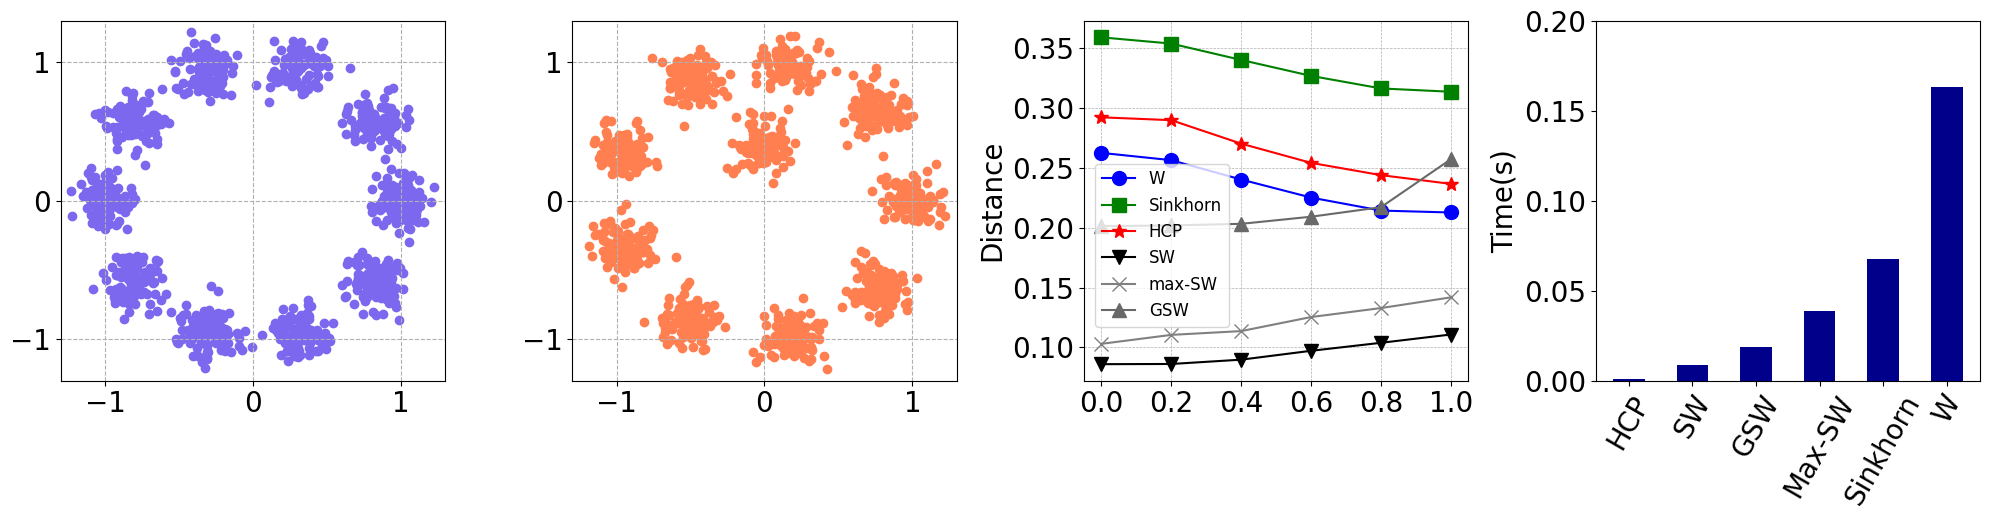

In [65]:
# generate source and target data
np.random.seed(2022)

meanx = make_ring(m,1)
meany = np.zeros((m,2))
meany[0,1] = 0.4
meany[1:,:] = make_ring(m-1,1)
sd = 0.1

x1 = np.zeros((n,2))
y1 = np.zeros((n,2))
for i in range(m):
    x1[i*nm:(i+1)*nm,:] = sd * np.random.randn(nm,2)+meanx[i,:] 
    y1[i*nm:(i+1)*nm,:] = sd * np.random.randn(nm,2)+meany[i,:] 

title_size = 20
abc_size = 30
cy = 'coral'
cx = 'mediumslateblue'
lim = 1.3
plt.style.use('default')  



plt.figure(2, figsize=(20, 5.3))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=1)


plt.subplot(1, 4, 1)
plt.xlim([-lim,lim])
plt.ylim([-lim,lim])
x_ticks = [-1,0,1]
plt.xticks(x_ticks,fontsize=20)
y_ticks = [-1,0,1]
plt.yticks(y_ticks,fontsize=20)
plt.scatter(x1[:,0],x1[:,1],c=cx)
plt.grid(linestyle='--')
plt.grid(linestyle='--')


plt.subplot(1, 4, 2)
plt.xlim([-lim,lim])
plt.ylim([-lim,lim])
x_ticks = [-1,0,1]
plt.xticks(x_ticks,fontsize=20)
y_ticks = [-1,0,1]
plt.yticks(y_ticks,fontsize=20)
plt.scatter(y1[:,0],y1[:,1],c=cy)
plt.grid(linestyle='--')
plt.grid(linestyle='--')


plt.subplot(1, 4, 3)
x_ticks = np.arange(0,2.2,0.2)
plt.xticks(x_ticks,fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('Distance',fontsize=20)
plt.plot(np.arange(0,1.2,0.2),w[0:6],c='b',label='W',marker='o',markersize=10)
plt.plot(np.arange(0,1.2,0.2),ws[0:6],c='g',label='Sinkhorn',marker='s',markersize=10)
plt.plot(np.arange(0,1.2,0.2),hcp[0:6],c='r',label='HCP',marker='*',markersize=10)
plt.plot(np.arange(0,1.2,0.2),sw[0:6],c='k',label='SW',marker='v',markersize=10)
plt.plot(np.arange(0,1.2,0.2),maxsw[0:6],c='grey',label='max-SW',marker='x',markersize=10)
plt.plot(np.arange(0,1.2,0.2),gsw5[0:6],c='dimgrey',label='GSW',marker='^',markersize=10)
plt.grid(linestyle = '--', linewidth = 0.5)
plt.legend(loc=(0.03,0.15),fontsize=12)
dist = ('HCP', 'SW', 'GSW', 'Max-SW','Sinkhorn','W')
times = [thcp,tsw,tgsw5,tmaxsw,tws,tw]

plt.subplot(1,4,4)
plt.bar(dist, times, color='darkblue', width=0.5)
plt.ylabel('Time(s)',fontsize=20)
plt.yticks([0,0.05,0.10,0.15,0.20],fontsize=20)
plt.xticks(rotation=60,fontsize=20)

plt.tight_layout()
plt.show()


# ring

In [66]:
# how many alpha: L  and  replications: R
L = 11
R = 20

d = 2
n = 1000
x = np.zeros((n,d))
y = np.zeros((n,d))
xx = [None]*L
yy = [None]*L

In [67]:
np.random.seed(2022)

w = np.zeros(L)
ws = np.zeros(L)
hcp = np.zeros(L)

sw = np.zeros(L)
maxsw = np.zeros(L)
gsw3 = np.zeros(L)
gsw5 = np.zeros(L)


tw = 0
thcp = 0
tsw = 0
tmaxsw = 0
tgsw5 = 0
tws = 0



for l in range(L):

    for r in range(R):

        # generate samples
        x = make_ring(n,1)
        y = np.zeros((n,2))
        y[100:,:] = make_ring(n-100,1)
        y[0:100,1] = l*0.2

        # SW
        stime = time.time()
        sw[l] += ot.sliced.sliced_wasserstein_distance(x, y, seed=2022) 
        tsw += time.time()-stime

        # max-SW
        stime = time.time()
        maxsw[l] += Maxsw(x, y) 
        tmaxsw += time.time()-stime

        xT = torch.from_numpy(x).float()
        yT = torch.from_numpy(y).float()

        # GSW3
        # stime = time.time()
        # loss = 0
        # for g in gsw[1]:
        #     loss += g.gsw(xT,yT)
        # gsw3[l] += np.array([loss])


        # GSW5
        stime = time.time()
        loss = 0
        for g in gsw[2]:
            loss += g.gsw(xT,yT)
        gsw5[l] += np.array([loss])
        tgsw5 += time.time()-stime


        # EMD
        stime = time.time()
        M = ot.dist(x,y)
        a = np.ones(n)/n
        b = np.ones(n)/n
        w[l] += np.sqrt(ot.emd2(a,b,M))
        tw += time.time()-stime


        # HPD
        stime = time.time()
        hcp[l] += HCP(x,y)
        thcp += time.time()-stime


        # Sinkhorn
        stime = time.time()
        M = ot.dist(x,y)
        a = np.ones(n)/n
        b = np.ones(n)/n
        ws[l] += np.sqrt(ot.bregman.sinkhorn2(a,b,M,reg=0.1,numItermax=100))
        tws += time.time()-stime
        
        
    xx[l] = x.copy()
    yy[l] = y.copy()

In [68]:
# take average
w = w/R
hcp = hcp/R
sw = sw/R
ws = ws/R
maxsw = maxsw/R
gsw5 = gsw5/R


RL = 20*11
tw = tw/RL
thcp = thcp/RL
tsw = tsw/RL
tws = tws/RL
tmaxsw = tmaxsw/RL
tgsw5 = tgsw5/RL

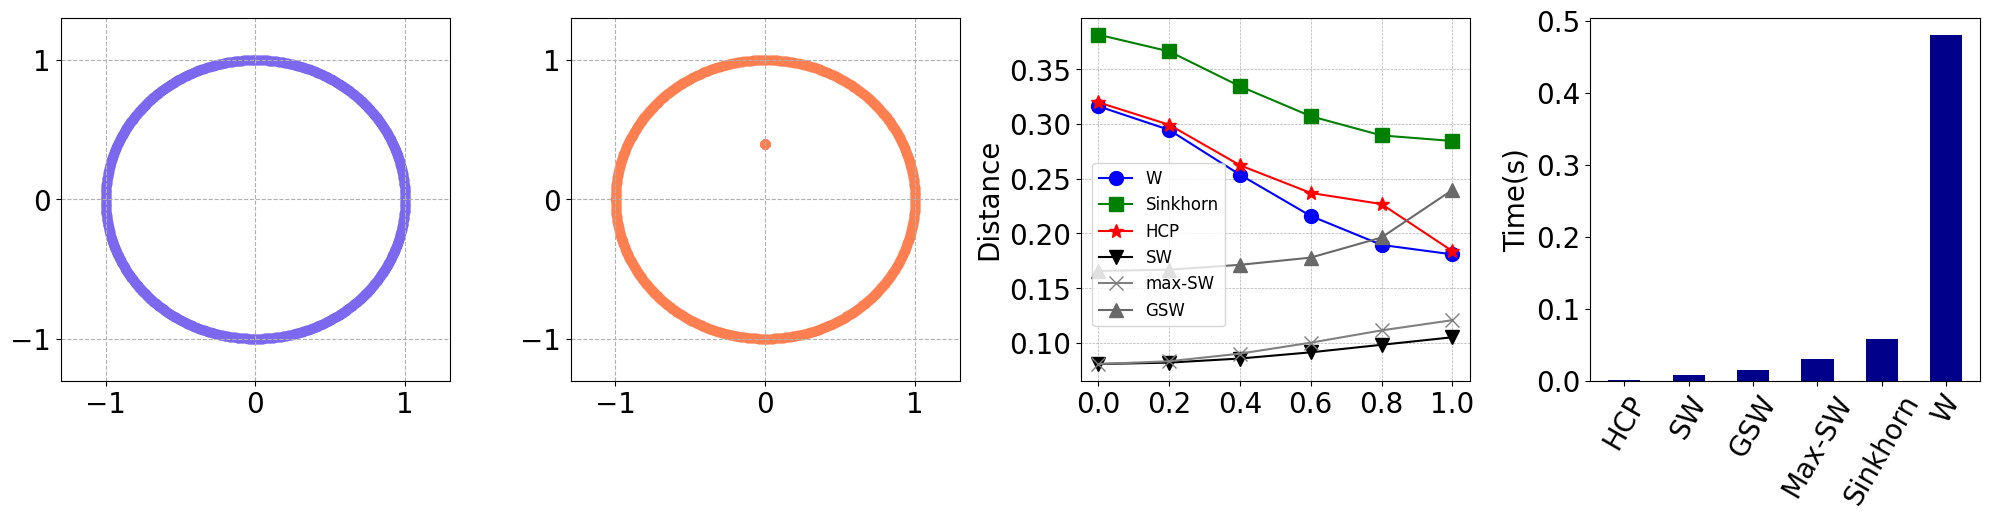

In [70]:
# generate source and target data
np.random.seed(2022)

x1 = make_ring(n,1)
y1 = np.zeros((n,2))
y1[100:,:] = make_ring(n-100,1)
y1[0:100,1] = 0.4


title_size = 20
abc_size = 30
cy = 'coral'
cx = 'mediumslateblue'
lim = 1.3
plt.style.use('default')  



plt.figure(2, figsize=(20, 5.3))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=1)


plt.subplot(1, 4, 1)
plt.xlim([-lim,lim])
plt.ylim([-lim,lim])
x_ticks = [-1,0,1]
plt.xticks(x_ticks,fontsize=20)
y_ticks = [-1,0,1]
plt.yticks(y_ticks,fontsize=20)
plt.scatter(x1[:,0],x1[:,1],c=cx)
plt.grid(linestyle='--')
plt.grid(linestyle='--')


plt.subplot(1, 4, 2)
plt.xlim([-lim,lim])
plt.ylim([-lim,lim])
x_ticks = [-1,0,1]
plt.xticks(x_ticks,fontsize=20)
y_ticks = [-1,0,1]
plt.yticks(y_ticks,fontsize=20)
plt.scatter(y1[:,0],y1[:,1],c=cy)
plt.grid(linestyle='--')
plt.grid(linestyle='--')


plt.subplot(1, 4, 3)
x_ticks = np.arange(0,2.2,0.2)
plt.xticks(x_ticks,fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('Distance',fontsize=20)
plt.plot(np.arange(0,1.2,0.2),w[0:6],c='b',label='W',marker='o',markersize=10)
plt.plot(np.arange(0,1.2,0.2),ws[0:6],c='g',label='Sinkhorn',marker='s',markersize=10)
plt.plot(np.arange(0,1.2,0.2),hcp[0:6],c='r',label='HCP',marker='*',markersize=10)
plt.plot(np.arange(0,1.2,0.2),sw[0:6],c='k',label='SW',marker='v',markersize=10)
plt.plot(np.arange(0,1.2,0.2),maxsw[0:6],c='grey',label='max-SW',marker='x',markersize=10)
plt.plot(np.arange(0,1.2,0.2),gsw5[0:6],c='dimgrey',label='GSW',marker='^',markersize=10)
plt.grid(linestyle = '--', linewidth = 0.5)
plt.legend(loc=(0.03,0.15),fontsize=12)
dist = ('HCP', 'SW', 'GSW', 'Max-SW','Sinkhorn','W')
times = [thcp,tsw,tgsw5,tmaxsw,tws,tw]

plt.subplot(1,4,4)
plt.bar(dist, times, color='darkblue', width=0.5)
plt.ylabel('Time(s)',fontsize=20)
plt.yticks([0,0.1,0.2,0.3,0.4,0.5],fontsize=20)
plt.xticks(rotation=60,fontsize=20)

plt.tight_layout()
plt.show()
